# Lab 6: Learning Word Embeddings

## What We're Building

This notebook uses a very simple neural network to teach machines to understand **word meaning** by analyzing how words appear together in context. We use **Skip-Gram with Negative Sampling (SGNS)** (the algorithm that powered **Word2Vec**) to transform words into vectors that capture semantic relationships.

## Pipeline Overview

```
📜 Captions from the Visual Genome dataset (a large text corpus)
    ↓
🔗 Word Co-occurrence Network (which words appear together?)
    ↓
🎯 Skip-Gram Neural Network (learn context-based representations)
    ↓
✨ Word Embeddings (numerical vectors that capture meaning)
```

## What Makes This Special?

Unlike ChatGPT or modern transformers that predict the *next* "token", Skip-Gram learns by predicting **surrounding context**. Given a word like "dog," it learns to predict "brown," "running," "park" (words that typically appear nearby).

The magic? Words used in similar contexts end up with similar vectors:
- **king** - **man** + **woman** ≈ **queen**
- **red**, **blue**, **green** cluster together
- **walking** is closer to **running** than to **chair**

## Why It Matters

These embeddings become the foundation for:
- 🔍 Search engines understanding query meaning
- 🤖 Chatbots grasping context
- 📊 Clustering and classification tasks
- 🧩 Solving word analogies

By the end, you'll train embeddings from 5 million image descriptions and visualize how language naturally organizes itself in vector space!

In [1]:
# ============================================================================
# Imports
# ============================================================================

# lab2: Network construction and visualization
# lab6: Data preparation and embedding training

import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent  # επειδή είσαι μέσα στο notebooks/
sys.path.insert(0, str(PROJECT_ROOT))

from src.lab6_current_best import prepare_visual_genome_text, train_embeddings, filter_punctuation_from_network
from src.lab2 import process_text_network, visualize_network

# 📚 Dataset: Visual Genome Region Descriptions

![Visual Genome example: region descriptions and scene graph](https://www.researchgate.net/publication/301844872/figure/fig30/AS:962204379660310@1606418809923/An-example-image-from-the-Visual-Genome-dataset-We-show-3-region-descriptions-and-their.gif)

## What is Visual Genome?

[Visual Genome](https://visualgenome.org/) is a large-scale dataset that pairs images with detailed text descriptions. It contains **~108K images** with **~5.4M region descriptions** — short phrases describing specific parts of each image.

**For this lab:** We use **only the text captions**, treating them as a large natural language corpus. We never process the images themselves. The graphic above simply shows where these captions come from.

---

## Why These Captions Work Well for Embeddings

- 🗣️ **Natural everyday language** — objects, colors, actions, relationships (*"man wearing blue shirt"*)
- 🔗 **Strong co-occurrence patterns** — words that belong together appear together frequently
- 🌍 **Diverse contexts** — indoor/outdoor scenes, people, animals, objects, activities
- 📈 **Large scale** — millions of phrases provide robust statistical signal

---

## Example Captions

```
a man wearing a blue shirt
red car parked on the street
woman holding a white umbrella
large tree behind a building
```

---

## What We'll Do

1. **Download** the JSON file containing all region descriptions
2. **Extract** text captions into a single `.txt` file
3. **Build** a word co-occurrence network from the text
4. **Train** Skip-Gram embeddings to learn word vectors

No image processing required — just pure text analysis!

In [2]:
# ============================================================================
# Step 1: Download and Prepare Text Data
# ============================================================================
# This downloads the Visual Genome region descriptions (JSON), extracts it,
# and converts all captions into a single plain text file for processing.
# Output: vg_text.txt (~80MB of text)

zip_url = "https://homes.cs.washington.edu/~ranjay/visualgenome/data/dataset/region_descriptions.json.zip"
text_file = prepare_visual_genome_text(zip_url)

print(f"\n✓ Text data ready: {text_file}")

File vg_text.txt already exists. Skipping processing.

✓ Text data ready: vg_text.txt


In [3]:
import math
from collections import defaultdict, Counter
from typing import Iterable, Optional
from typing import List, Dict, Set, Tuple


# ----------------------------------------------------------------------------
# Text tokenization (simple, no external libs)
# ----------------------------------------------------------------------------
def _simple_tokenize(text: str) -> List[str]:
    """
    Simple tokenizer:
    - lowercase
    - keeps letters/digits and apostrophe
    - splits on anything else
    """
    text = text.lower()
    tokens = []
    buff = []

    for ch in text:
        if ch.isalnum() or ch == "'":
            buff.append(ch)
        else:
            if buff:
                tok = "".join(buff)
                tokens.append(tok)
                buff = []
    if buff:
        tokens.append("".join(buff))

    return tokens


def _iter_vg_docs_from_txt(
    vg_text_path: str,
    delimiter: str = " . ",
    chunk_size: int = 1_000_000
) -> Iterable[str]:
    """
    Stream documents from vg_text.txt without loading all into memory.

    We treat each piece between delimiter occurrences as one "doc" (phrase).
    This matches how prepare_visual_genome_text writes the file: " . ".join(phrases)
    """
    carry = ""
    with open(vg_text_path, "r", encoding="utf-8") as f:
        while True:
            chunk = f.read(chunk_size)
            if not chunk:
                break
            data = carry + chunk
            parts = data.split(delimiter)
            # all except last are full docs; last is carry
            for doc in parts[:-1]:
                if doc:
                    yield doc
            carry = parts[-1]

    if carry:
        yield carry


# ----------------------------------------------------------------------------
# 1) IDF computation
# ----------------------------------------------------------------------------
def compute_idf_from_vg_text(
    vg_text_path: str,
    vocab: Optional[Set[str]] = None,
    delimiter: str = " . ",
    smooth: bool = True
) -> Dict[str, float]:
    """
    Compute IDF from vg_text.txt where each doc is a phrase/sentence split by delimiter.

    Args:
        vg_text_path: path to vg_text.txt
        vocab: if provided, compute IDF only for these tokens (recommended: network_data['nodes'])
        delimiter: doc separator used when vg_text.txt was created (" . ")
        smooth: apply smoothing: idf = log((N+1)/(df+1)) + 1, else log(N/df)

    Returns:
        idf: dict token -> idf score
    """
    df = Counter()
    N = 0

    vocab_set = set(vocab) if vocab is not None else None

    for doc in _iter_vg_docs_from_txt(vg_text_path, delimiter=delimiter):
        tokens = _simple_tokenize(doc)
        if not tokens:
            continue

        if vocab_set is not None:
            doc_terms = set(t for t in tokens if t in vocab_set)
        else:
            doc_terms = set(tokens)

        if not doc_terms:
            continue

        N += 1
        for t in doc_terms:
            df[t] += 1

    idf: Dict[str, float] = {}
    if N == 0:
        return idf

    if smooth:
        for t, dft in df.items():
            idf[t] = math.log((N + 1.0) / (dft + 1.0)) + 1.0
    else:
        for t, dft in df.items():
            # Avoid division by zero; df should never be 0 for seen terms
            idf[t] = math.log(N / float(dft))

    return idf


# ----------------------------------------------------------------------------
# 2) Co-occurrence metadata (same-doc cooccurrence)
# ----------------------------------------------------------------------------
def build_cooccur_metadata(
    vg_text_path: str,
    vocab: Set[str],
    delimiter: str = " . ",
    max_neighbors_per_word: Optional[int] = None
) -> Dict[str, Set[str]]:
    """
    Build a co-occurrence map: for each word in vocab, which other vocab words
    have appeared in the same doc (phrase).

    Args:
        vg_text_path: path to vg_text.txt
        vocab: set of tokens we care about (e.g., filtered network nodes)
        delimiter: doc separator used when vg_text.txt was created (" . ")
        max_neighbors_per_word: optional cap to keep sets bounded (None = no cap)

    Returns:
        cooccur: dict word -> set of co-occurring words (within same doc)
    """
    vocab_set = set(vocab)
    cooccur: Dict[str, Set[str]] = {w: set() for w in vocab_set}

    for doc in _iter_vg_docs_from_txt(vg_text_path, delimiter=delimiter):
        tokens = _simple_tokenize(doc)
        if not tokens:
            continue

        doc_vocab_terms = set(t for t in tokens if t in vocab_set)
        if len(doc_vocab_terms) <= 1:
            continue

        # Update cooccur sets
        # For each w in doc, add all others (doc_terms - {w})
        for w in doc_vocab_terms:
            others = doc_vocab_terms - {w}
            if not others:
                continue

            if max_neighbors_per_word is None:
                cooccur[w].update(others)
            else:
                # bounded growth: add until cap
                remaining = max_neighbors_per_word - len(cooccur[w])
                if remaining <= 0:
                    continue
                # add up to remaining
                for o in others:
                    cooccur[w].add(o)
                    remaining -= 1
                    if remaining == 0:
                        break

    return cooccur


In [4]:
import numpy as np
import math

def compute_ppmi_from_vg_text(
    vg_text_path: str,
    vocab: list[str],
    vocab_set: set[str],
    window: int = 5,
    delimiter: str = " . ",
    min_count: int = 2,
    eps: float = 1e-12,
) -> np.ndarray:
    V = len(vocab)
    node_to_idx = {w:i for i,w in enumerate(vocab)}

    C = np.zeros((V, V), dtype=np.int64)
    f = np.zeros(V, dtype=np.int64)

    def simple_tokenize(s: str) -> list[str]:
        s = s.lower()
        out = []
        cur = []
        for ch in s:
            if ch.isalnum() or ch == "'":
                cur.append(ch)
            else:
                if cur:
                    out.append("".join(cur))
                    cur = []
        if cur:
            out.append("".join(cur))
        return out

    with open(vg_text_path, "r", encoding="utf-8") as f_in:
        text = f_in.read()

    # split into “docs/phrases”
    docs = text.split(delimiter)

    for doc in docs:
        toks = [t for t in simple_tokenize(doc) if t in vocab_set]
        if not toks:
            continue

        idxs = [node_to_idx[t] for t in toks]
        for i, wi in enumerate(idxs):
            f[wi] += 1
            left = max(0, i - window)
            right = min(len(idxs), i + window + 1)
            for j in range(left, right):
                if j == i:
                    continue
                cj = idxs[j]
                C[wi, cj] += 1

    # PPMI
    total = C.sum()
    if total == 0:
        return np.zeros((V, V), dtype=np.float32)

    row = C.sum(axis=1).astype(np.float64)  # ~ f(w) in cooc space
    col = C.sum(axis=0).astype(np.float64)  # f(c)

    PPMI = np.zeros((V, V), dtype=np.float32)

    # compute only where count >= min_count
    nz = np.argwhere(C >= min_count)
    for wi, cj in nz:
        p_wc = C[wi, cj] / (total + eps)
        p_w  = row[wi] / (total + eps)
        p_c  = col[cj] / (total + eps)
        pmi = math.log(p_wc / (p_w * p_c + eps) + eps)  # log base e (base δεν αλλάζει ranking)
        if pmi > 0:
            PPMI[wi, cj] = pmi

    return PPMI

In [5]:
# ============================================================================
# Step 2: Build Word Co-occurrence Network (will take a few minutes)
# ============================================================================
# Using your process_text_network() function from Lab 2
# This tokenizes the text, counts word co-occurrences, and builds a network
# where nodes are words and edges connect words that appear near each other.
#
# rare_threshold: Filters out uncommon words (keeps top ~0.025% by frequency)
# This gives us ~500 most common words to work with.

print("\n" + "="*80)
print("BUILDING TEXT NETWORK")
print("="*80)

network_data = process_text_network(
    text_file,
    rare_threshold=0.00025,  # Keep only very common tokens
    verbose=True
)

print(f"\n✓ Network built: {network_data['graph'].number_of_nodes():,} nodes, "
      f"{network_data['graph'].number_of_edges():,} edges")


BUILDING TEXT NETWORK
Loaded text: 154199868 characters
Tokenized: 27533256 tokens
Sample tokens: ['smoooth', 'worked', 'swallowing', 'crd', 'pokes', 'dammaged', 'amusement', 'walkiing', 'convoi', 'calla', 'peoppe', 'apothecary', 'strayed', 'fina', 'upholsered', 'obscurred', 'twin', 'shadwo', 'uno', 'alrm']
Replaced 62380 rare tokens (threshold=0.00025)
Final vocabulary: 456 unique tokens
Sample tokens: ['vase', 'paper', 'dark', 'track', 'cloud', 'girl', 'chair', 'from', 'table', 'cement', 'bottom', 'design', 'growing', 'fork', 'ground', 'letters', 'black', 'purple', 'closed', 'bright']
Graph: 456 nodes, 84581 edges
Top tokens by frequency:
   1. '<RARE>' (freq=4416304)
   2. 'a' (freq=2220903)
   3. 'the' (freq=2155082)
   4. 'on' (freq=1396037)
   5. 'of' (freq=980462)
   6. 'is' (freq=787911)
   7. 'in' (freq=714868)
   8. 'white' (freq=652421)
   9. 'black' (freq=398632)
  10. 'and' (freq=341934)

✓ Network built: 456 nodes, 84,581 edges


In [6]:
vocab = set(network_data["nodes"])

idf = compute_idf_from_vg_text(text_file, vocab=vocab)
cooccur = build_cooccur_metadata(text_file, vocab=vocab)

print("Finished")
print(idf["man"])


Finished
3.832402002281041


In [7]:
network_data = filter_punctuation_from_network(network_data)

vocab_list = list(network_data["nodes"])     # ordered list, ίδιο order με embeddings
vocab_set  = set(vocab_list)

ppmi_matrix = compute_ppmi_from_vg_text(
    vg_text_path=text_file,
    vocab=vocab_list,
    vocab_set=vocab_set,
    window=5,
    delimiter=" . ",
    min_count=2
)


🔧 PUNCTUATION FILTER:
  Removed: {'.', "'", ',', '<RARE>'}
  Nodes: 456 → 455
  Edges: 84,581 → 84,126


In [8]:
print("WRONG")
print(idf["woman"],idf["man"], idf["sky"], idf["water"], idf["person"])

print("Correct")
print(idf["street"], idf["car"], idf["snow"], idf["sand"], idf["grass"], idf["standing"], idf["sitting"], idf["walking"], idf["table"])

WRONG
4.6611652965896235 3.832402002281041 4.728650370812072 4.849213049919181 4.618316829232085
Correct
5.185291783171384 5.296228585811391 5.507458392675364 6.583637067668913 5.045471032989393 5.4258037748758134 5.453875462713556 6.009454553027927 4.856782354479445


In [9]:
print(cooccur["person"])

{'luggage', 'floor', 'beside', 'it', 'wheel', 'shoes', 'clouds', 'counter', 'airplane', 'wood', 'his', 'surfer', 'legs', 'flying', 'under', 'very', 'colorful', 'chain', 'parking', 'some', 'and', 'row', 'being', 'rail', 'brick', 'hydrant', 'suit', 'mirror', 'bottle', 'train', 'wrist', 'spoon', 'sand', 'towel', 'giraffes', 'riding', 'foot', 'front', 'wearing', 'cover', 'green', 'field', 'arm', 'door', 'face', 'rocks', 'animal', 'frisbee', 'two', 'cloth', 'sandwich', 'smiling', 'clock', 'letter', 'stripes', 'suitcase', 'bridge', 'by', 'passenger', 'blue', 'surface', 'zebra', 'road', 'beige', 'outside', 't', 'dog', 'man', 'boat', 'off', 'hand', 'walking', 'orange', 'bicycle', 'bird', 'has', 'waves', 'collar', 'sink', 'body', 'elephants', 'cow', 'carrying', 'coffee', 'stop', 'sweater', 'sign', 'lights', 'up', 'fence', 'knife', 'windshield', 'sheep', 'racket', 'screen', 'leaves', 'ear', 'cap', 'guy', 'yellow', 'hot', 'gray', 'pillow', 'cup', 'platform', 'an', 'line', 'visible', 'nose', 'pole

In [10]:
import numpy as np

def inspect_cooccurrences(
    word: str,
    cooccur: dict,
    idf: dict,
    ppmi_matrix: np.ndarray,
    vocab_list: list[str],
    min_ppmi: float = 0.0,
    sort_by: str = "idf",   # "ppmi" | "idf" | "both"
    top_k: int | None = 30,
):
    """
    Για μια λέξη `word`:
      - εμφανίζει όλα τα co-occurrences (από cooccur[word])
      - για κάθε context δείχνει idf(context) και PPMI(word, context)
    Με ασφάλεια ως προς alignment: κρατά μόνο contexts που υπάρχουν στο vocab_list.
    """

    node_to_idx = {w: i for i, w in enumerate(vocab_list)}

    if word not in node_to_idx:
        print(f"❌ '{word}' δεν υπάρχει στο vocab_list (μετά το punctuation filter).")
        return

    if word not in cooccur:
        print(f"❌ '{word}' δεν υπάρχει ως key στο cooccur dict.")
        return

    w_idx = node_to_idx[word]

    rows = []
    for ctx in cooccur.get(word, []):
        # keep only contexts that exist in vocab_list (so ppmi index is valid)
        if ctx not in node_to_idx:
            continue

        c_idx = node_to_idx[ctx]
        pp = float(ppmi_matrix[w_idx, c_idx])

        if pp < min_ppmi:
            continue

        rows.append({
            "context": ctx,
            "idf": float(idf.get(ctx, np.nan)),
            "ppmi": pp
        })

    if not rows:
        print(f"⚠️ Δεν βρέθηκαν contexts (μετά από filtering) για '{word}'.")
        return

    # Sorting
    if sort_by == "ppmi":
        rows.sort(key=lambda r: r["ppmi"], reverse=True)
    elif sort_by == "idf":
        rows.sort(key=lambda r: (r["idf"] if not np.isnan(r["idf"]) else -1e9), reverse=True)
    elif sort_by == "both":
        # simple combined score: ppmi * normalized-ish idf factor
        rows.sort(
            key=lambda r: r["ppmi"] * (1.0 + (r["idf"] if not np.isnan(r["idf"]) else 0.0)),
            reverse=True
        )
    else:
        raise ValueError("sort_by must be one of: 'ppmi', 'idf', 'both'")

    if top_k is not None:
        rows = rows[:top_k]

    print(f"\n🔍 Co-occurrences για '{word}'  |  (contexts in vocab: {len(rows)})")
    print(f"{'context':<16} {'idf':>8} {'ppmi':>10}")
    print("-" * 38)
    for r in rows:
        idf_str = f"{r['idf']:.3f}" if not np.isnan(r["idf"]) else "NaN"
        print(f"{r['context']:<16} {idf_str:>8} {r['ppmi']:>10.4f}")


In [11]:
print("WRONG-ish (low-idf words)")
for w in ["woman", "man", "sky", "water", "person", "white"]:
    inspect_cooccurrences(w, cooccur, idf, ppmi_matrix, vocab_list, sort_by="both", top_k=20)

print("\nCorrect-ish (higher-idf words)")
for w in ["street", "car", "snow", "sand", "grass", "standing", "sitting", "walking", "table"]:
    inspect_cooccurrences(w, cooccur, idf, ppmi_matrix, vocab_list, sort_by="both", top_k=20)


WRONG-ish (low-idf words)

🔍 Co-occurrences για 'woman'  |  (contexts in vocab: 20)
context               idf       ppmi
--------------------------------------
blonde              7.568     2.6548
smiling             7.642     2.5736
her                 7.144     2.6290
dress               7.284     2.5103
carrying            7.382     2.3802
wears               7.457     2.2032
sweater             7.602     2.0320
sunglasses          7.217     2.0932
tank                7.609     1.7213
coat                7.039     1.8316
playing             6.768     1.8058
hair                5.585     2.0783
glasses             6.591     1.7388
cell                7.338     1.5118
jeans               6.768     1.5775
holding             5.464     1.8766
worn                7.475     1.3272
skiing              7.651     1.2607
phone               6.488     1.4049
wearing             4.245     1.9546

🔍 Co-occurrences για 'man'  |  (contexts in vocab: 20)
context               idf       ppmi
-------

In [12]:
threshold = 4.8

low_idf_words = [
    (w, idf[w]) for w in idf
    if idf[w] < threshold
]

# Ταξινόμηση από το μικρότερο idf προς το μεγαλύτερο
low_idf_words.sort(key=lambda x: x[1])

for w, score in low_idf_words:
    print(f"{w:15s} idf={score:.3f}")

a               idf=2.031
the             idf=2.051
on              idf=2.356
of              idf=2.718
is              idf=2.926
in              idf=3.027
white           idf=3.117
black           idf=3.610
and             idf=3.765
man             idf=3.832
with            idf=3.916
blue            idf=3.949
red             idf=4.127
green           idf=4.145
wearing         idf=4.245
brown           idf=4.372
building        idf=4.511
are             idf=4.595
person          idf=4.618
woman           idf=4.661
this            idf=4.676
wall            idf=4.707
sky             idf=4.729
window          idf=4.740
yellow          idf=4.741
shirt           idf=4.764
sign            idf=4.789


In [13]:
stopwords = {
    "the", "a", "and", "this", "to", "in", "is", "for", "on", "at", "an", "of", "can", "has",
    "with","are","was","were","that","these","those","it","as","by","from", "his", "her", "he", "she", "it", "they"
}
vocab = set(network_data["nodes"])

stopwords_in_graph = stopwords.intersection(vocab)

print(stopwords_in_graph)


{'an', 'with', 'of', 'it', 'by', 'for', 'can', 'his', 'from', 'to', 'on', 'and', 'her', 'has', 'he', 'at', 'a', 'that', 'is', 'the', 'in', 'these', 'are', 'this'}


## How We'll Train Our Network Embeddings

Now that you've seen the complete code, let's review the big picture. We're using PyTorch, a deep learning framework, to build and train our model. The whole process fits together like this:

```
📦 Dataset  →  🔄 DataLoader  →  🧠 Model  →  📈 Training Loop
```

The two key classes you just saw, **`SkipGramDataset`** and **`SkipGramModel`**, handle all the core logic for this.

-----

## The Big Picture: From Graphs to Embeddings

In a standard Skip-Gram model, the "context" is just the words nearby in a sentence. Our model is more advanced: **our context comes from the network graph.**

  * **Center Word:** A node in the graph (e.g., `"dog"`)
  * **Context Word:** A node connected by an edge (e.g., `"runs"`)

The training process (which you'll run next) follows this flow:

```
Network Data (word graph)
    ↓
SkipGramDataset
    • Takes word pairs from graph: (center, context_neighbor)
    • Samples negative examples (random words NOT in context)
    • Returns: (center, context, [neg₁, neg₂, ..., negₖ])
    ↓
DataLoader (batches data using WeightedRandomSampler)
    ↓
SkipGramModel
    • Embeddings: center words → vectors
    • Embeddings: context words → vectors
    • Compute similarity scores
    • Loss: maximize score for real neighbors, minimize for negatives
    ↓
Backpropagation (update embeddings)
    ↓
Repeat until convergence
```

-----

## Key Features in the Code

The code you just saw has three key features. Here’s *why* they are so important.

### 1\. Why Negative Sampling?

**Problem:** Our vocabulary has thousands of words. For the center word `"dog"`, calculating the probability for *every other word* (e.g., "cat", "runs", "airplane", "purple"...) to be its context is extremely slow.

**Solution:** We change the problem. Instead of "predict the context word," we ask a simpler, binary question:

  * ✅ **Positive Example:** Is `"runs"` (a real neighbor) in the context of `"dog"`? → **Train to output YES (score ≈ 1)**
  * ❌ **Negative Example:** Is `"airplane"` (a random word) in the context of `"dog"`? → **Train to output NO (score ≈ 0)**
  * ❌ **Negative Example:** Is `"purple"` (a random word) in the context of `"dog"`? → **Train to output NO (score ≈ 0)**

This is **Negative Sampling**. By training the model to distinguish between 1 positive example and \~15 negative ones (`num_negative=15`), we get a massive speedup and still learn high-quality embeddings.

### 2\. Why Weighted Sampling?

**Problem:** Not all neighbors are equally important. A pair like `("man", "walking")` might be very common and meaningful, while `("man", "street")` is also common but maybe less specific.

**Solution:** We use `WeightedRandomSampler` in the `train_embeddings` function. This sampler uses the **weights** from our `SkipGramDataset`, which are based on the `distance_matrix` (co-occurrence frequency).

This forces the training loop to **pay more attention to strong, frequent pairs**, sampling them more often and learning their relationship better.

### 3\. Why Filter Punctuation?

**Problem:** You saw the `filter_punctuation_from_network` function. Why bother?

**Solution: Hub Poisoning.** Think about the word `"."` (a period). It's a "neighbor" to the last word of *every single sentence*. This makes it a massive, meaningless "hub" that connects thousands of unrelated words.

If we left punctuation in, the model would waste most of its effort learning that "everything is related to a period." By removing it, we force the model to learn *actual semantic relationships* between words.

-----

## What's Next?

Now that you understand the "what" and the "why," it's time to put it all together. In the following cells, you will:

1.  **Load** the text data and **build** the network.
2.  **Run** the `train_embeddings` function to train your model.
3.  **Analyze** the resulting embeddings to see what the model learned\!

# 🛠️ Implementation Guide: What You'll Build

You will implement the two core PyTorch classes we just reviewed. The skeletons are provided in lab6.py.

## Part 1: `SkipGramDataset` (Data Preparation)

### Purpose

A PyTorch `Dataset` is responsible for fetching and preparing individual training examples. Our `Dataset` will convert our **graph** into `(center, context, negatives)` triples.

### Class Structure

```python
class SkipGramDataset(torch.utils.data.Dataset):
    def __init__(self, graph, nodes, distance_matrix, num_negative=15, context_size=1):
        # Setup: build vocabulary, create training pairs, prepare negative sampling
        
    def __len__(self):
        # Return: total number of training examples
        
    def __getitem__(self, idx):
        # Return: (center_idx, context_idx, negative_indices)
```

### What You'll Implement

**`__init__` (Setup)**

  * Create a mapping: `self.node_to_idx` (e.g., "dog" → 42).
  * Build `self.contexts`: For each word, find its neighbors within `context_size` hops in the `graph`.
  * Generate `self.pairs` and `self.weights`: Create a list of all `(center, context)` pairs and use the `distance_matrix` to create a sampling weight for each pair.

**`__len__`** (Easy\!)

  * Return the total number of positive training pairs.

**`__getitem__` (Core Logic)**

  * Get the `(center_idx, context_idx)` pair for the given `idx`.
  * Sample `num_negative` random word indices from the entire vocabulary.
  * **Crucial Step:** Your negative samples must **exclude** the `center_idx` and *all* of its context words (use `self.contexts` to check).
  * Return the `center_idx`, `context_idx`, and the array of `negatives` as integer types (e.g., `np.int64`).

-----

## Part 2: `SkipGramModel` (The Neural Network)

### Purpose

A PyTorch `nn.Module` is your neural network. It defines the architecture (the "layers") and the `forward` pass (how data flows through it to compute a loss).

### Class Structure

```python
class SkipGramModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, dropout=0.3):
        # Setup: create embedding layers and dropout
        
    def forward(self, center, context, negatives, apply_dropout=True, label_smoothing=0.1):
        # Compute loss for this batch
        # Return: batch of loss values
```

### What You'll Implement

**`__init__` (Architecture)**

  * Create **two** embedding layers (`nn.Embedding`):
      * `self.center_embeddings`: (vocab\_size, embedding\_dim)
      * `self.context_embeddings`: (vocab\_size, embedding\_dim)
  * Create a `self.dropout` layer (`nn.Dropout`).
  * Call `self._init_embeddings()` to initialize the weights.

**`forward` (The Core Logic)**

This is where you'll compute the loss. You need to implement these steps:

1.  **Look up Embeddings:**

      * Get the `center_emb` vector(s) from `self.center_embeddings`.
      * Get the `context_emb` vector(s) from `self.context_embeddings`.
      * Get the `negative_emb` vectors from `self.context_embeddings`.

2.  **Apply Regularization:**

      * Apply the `self.dropout` layer to `center_emb` (but only if `apply_dropout` is `True`).

3.  **Compute Scores (Dot Products):**

      * `pos_score`: Compute the dot product between `center_emb` and `context_emb`.
      * `neg_score`: Compute the dot products between `center_emb` and *all* of its `negative_emb` vectors. (Hint: `torch.bmm` is great for this).

4.  **Compute Loss (with Label Smoothing):**

      * This is the most important part. You **cannot** use a simple loss function.
      * You must implement the loss manually using `F.logsigmoid` as shown in the lecture.
      * Calculate the loss for the `pos_score` using the `label_smoothing` value (target is `1.0 - label_smoothing`).
      * Calculate the loss for the `neg_score` using the `label_smoothing` value (target is `0.0 + label_smoothing`).
      * The total loss is the *negative* sum of the positive loss and the negative loss.

### Key Insight

The model's goal is to make the `center_emb` vector similar to its `context_emb` and **dissimilar** from all `negative_emb` vectors. The **dropout** and **label smoothing** are crucial regularization techniques to prevent overfitting and help the model generalize better.

-----

Now you're ready to implement these classes. The skeleton code is provided below with `TODO`s marking what you need to fill in.

In [14]:
import os
from IPython.display import Image, display
from src.lab6_current_best import train_embeddings

print("\n" + "="*80)
print("🚀 STARTING TRAINING RUN")
print("This may take a few minutes. We are running the full pipeline...")
print("="*80)

# --- Hyperparameters ---
# We're using a smaller dimension (64 for speed).
# A wide context_size (4) captures broader graph relationships.
# The batch size is large for GPU efficiency.
results = train_embeddings(
    network_data=network_data,
    embedding_dim=96,        # Dimension of the learned vectors
    batch_size=2048,         # Number of pairs per training step
    epochs=45,               # Max epochs (will stop early)
    learning_rate=0.001,     # AdamW learning rate
    num_negative=8,          # 8 negatives per 1 positive
    validation_fraction=0.1, # Use 10% of edges for validation
    context_size=4,          # Use neighbors up to 4 hops away

    # --- Regularization Stack ---
    dropout=0.3,             # Prevent neuron co-adaptation
    weight_decay=1e-4,       # L2 penalty to keep weights small
    label_smoothing=0.1,     # Prevent overconfidence (target 0.9, not 1.0)
    patience=5,              # Stop if val_loss doesn't improve for 5 epochs
    device=None,              # Auto-detects 'cuda' or 'cpu'
    cooccur=cooccur,
    stopwords=stopwords_in_graph,
    idf = idf,
    ppmi_matrix = ppmi_matrix,
    idf_threshold=4.8, 
    low_idf_context_size=2,
    ppmi_alpha=1.0, 
    ctx_idf_beta=1.0
)

# --- Training Summary ---
nodes = results['nodes']
embeddings = results['embeddings']

print("\n" + "="*80)
print("✅ TRAINING COMPLETE")
print("="*80)
print(f"Learned embeddings for {len(nodes):,} words")
print(f"Embedding dimension: {embeddings.shape[1]}")
print(f"\n💡 Key features of this training run:")
print(f"  • Punctuation filtering prevented 'hub poisoning'")
print(f"  • Weighted sampling focused on important pairs")
print(f"  • Regularization (Dropout, L2, Smoothing) prevented overfitting")
print(f"  • A wide context (size=4) learned from the graph structure")


🚀 STARTING TRAINING RUN
This may take a few minutes. We are running the full pipeline...

🔧 PUNCTUATION FILTER:
  Removed: {'.', "'", ',', '<RARE>'}
  Nodes: 455 → 455
  Edges: 84,126 → 84,126

Train edges: 75,713, Val edges: 8,413

📊 SkipGramDataset Statistics:
  Vocabulary size: 455
  Positive pairs: 154,940
  Negatives per positive: 8
  Total samples per epoch: 1,394,460

  Weight distribution:
    Min: 0.245397
    Mean: 1.000000
    Median: 0.520567
    Max: 10.147712

📊 SkipGramDataset Statistics:
  Vocabulary size: 455
  Positive pairs: 154,698
  Negatives per positive: 8
  Total samples per epoch: 1,392,282

  Weight distribution:
    Min: 0.246971
    Mean: 1.000000
    Median: 0.523904
    Max: 10.104696


c:\Users\paris\Desktop\AI_CW2\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Training on cpu
Vocab: 455, Embed dim: 96, Context: 4, Negatives: 8
Regularization: dropout=0.3, weight_decay=0.0001, label_smoothing=0.1


Epoch 01  train=5.7899  val=4.3645  lr=0.001000
  → Best model (val_loss=4.3645), saved to best_model.pth


Epoch 02  train=4.4137  val=3.2318  lr=0.001000
  → Best model (val_loss=3.2318), saved to best_model.pth


Epoch 03  train=4.3006  val=3.2240  lr=0.001000
  → Best model (val_loss=3.2240), saved to best_model.pth


Epoch 04  train=4.2997  val=3.2219  lr=0.001000
  → Best model (val_loss=3.2219), saved to best_model.pth


Epoch 05  train=4.2975  val=3.2160  lr=0.001000
  → Best model (val_loss=3.2160), saved to best_model.pth


Epoch 06  train=4.2893  val=3.1977  lr=0.001000
  → Best model (val_loss=3.1977), saved to best_model.pth


Epoch 07  train=4.2692  val=3.1626  lr=0.001000
  → Best model (val_loss=3.1626), saved to best_model.pth


Epoch 08  train=4.2481  val=3.1342  lr=0.001000
  → Best model (val_loss=3.1342), saved to best_model.pth


Epoch 09  train=4.2384  val=3.1173  lr=0.001000
  → Best model (val_loss=3.1173), saved to best_model.pth


Epoch 10  train=4.2353  val=3.1113  lr=0.001000
  → Best model (val_loss=3.1113), saved to best_model.pth


Epoch 11  train=4.2330  val=3.1059  lr=0.001000
  → Best model (val_loss=3.1059), saved to best_model.pth


Epoch 12  train=4.2318  val=3.1041  lr=0.001000
  → Best model (val_loss=3.1041), saved to best_model.pth


Epoch 13  train=4.2312  val=3.1012  lr=0.001000
  → Best model (val_loss=3.1012), saved to best_model.pth


Epoch 14  train=4.2302  val=3.0989  lr=0.001000
  → Best model (val_loss=3.0989), saved to best_model.pth


Epoch 15  train=4.2260  val=3.0915  lr=0.001000
  → Best model (val_loss=3.0915), saved to best_model.pth


Epoch 16  train=4.2242  val=3.0888  lr=0.001000
  → Best model (val_loss=3.0888), saved to best_model.pth


Epoch 17  train=4.2222  val=3.0843  lr=0.001000
  → Best model (val_loss=3.0843), saved to best_model.pth


Epoch 18  train=4.2158  val=3.0729  lr=0.001000
  → Best model (val_loss=3.0729), saved to best_model.pth


Epoch 19  train=4.2116  val=3.0664  lr=0.001000
  → Best model (val_loss=3.0664), saved to best_model.pth


Epoch 20  train=4.2056  val=3.0539  lr=0.001000
  → Best model (val_loss=3.0539), saved to best_model.pth


Epoch 21  train=4.2015  val=3.0440  lr=0.001000
  → Best model (val_loss=3.0440), saved to best_model.pth


Epoch 22  train=4.1970  val=3.0369  lr=0.001000
  → Best model (val_loss=3.0369), saved to best_model.pth


Epoch 23  train=4.1947  val=3.0328  lr=0.001000
  → Best model (val_loss=3.0328), saved to best_model.pth


Epoch 24  train=4.1944  val=3.0289  lr=0.001000
  → Best model (val_loss=3.0289), saved to best_model.pth


Epoch 25  train=4.1902  val=3.0212  lr=0.001000
  → Best model (val_loss=3.0212), saved to best_model.pth


Epoch 26  train=4.1860  val=3.0139  lr=0.001000
  → Best model (val_loss=3.0139), saved to best_model.pth


Epoch 27  train=4.1855  val=3.0108  lr=0.001000
  → Best model (val_loss=3.0108), saved to best_model.pth


Epoch 28  train=4.1837  val=3.0059  lr=0.001000
  → Best model (val_loss=3.0059), saved to best_model.pth


Epoch 29  train=4.1801  val=3.0016  lr=0.001000
  → Best model (val_loss=3.0016), saved to best_model.pth


Epoch 30  train=4.1820  val=3.0016  lr=0.001000
  → Best model (val_loss=3.0016), saved to best_model.pth


Epoch 31  train=4.1795  val=2.9980  lr=0.001000
  → Best model (val_loss=2.9980), saved to best_model.pth


Epoch 32  train=4.1779  val=2.9942  lr=0.001000
  → Best model (val_loss=2.9942), saved to best_model.pth


Epoch 33  train=4.1775  val=2.9931  lr=0.001000
  → Best model (val_loss=2.9931), saved to best_model.pth


Epoch 34  train=4.1784  val=2.9933  lr=0.001000


Epoch 35  train=4.1751  val=2.9882  lr=0.001000
  → Best model (val_loss=2.9882), saved to best_model.pth


Epoch 36  train=4.1752  val=2.9874  lr=0.001000
  → Best model (val_loss=2.9874), saved to best_model.pth


Epoch 37  train=4.1739  val=2.9836  lr=0.001000
  → Best model (val_loss=2.9836), saved to best_model.pth


Epoch 38  train=4.1752  val=2.9857  lr=0.001000


Epoch 39  train=4.1735  val=2.9809  lr=0.001000
  → Best model (val_loss=2.9809), saved to best_model.pth


Epoch 40  train=4.1711  val=2.9765  lr=0.001000
  → Best model (val_loss=2.9765), saved to best_model.pth


Epoch 41  train=4.1718  val=2.9781  lr=0.001000


Epoch 42  train=4.1718  val=2.9783  lr=0.001000


Epoch 43  train=4.1713  val=2.9773  lr=0.001000


Epoch 44  train=4.1703  val=2.9778  lr=0.000500


Epoch 45  train=4.1692  val=2.9753  lr=0.000500
  → Best model (val_loss=2.9753), saved to best_model.pth

Saved loss plot to training_loss.png

✅ TRAINING COMPLETE
Learned embeddings for 455 words
Embedding dimension: 96

💡 Key features of this training run:
  • Punctuation filtering prevented 'hub poisoning'
  • Weighted sampling focused on important pairs
  • Regularization (Dropout, L2, Smoothing) prevented overfitting
  • A wide context (size=4) learned from the graph structure


Loading best model from best_model.pth...
✅ Loaded embeddings for 455 words

EMBEDDING ANALYSIS

Vocabulary: 455  Embedding dim: 96

Similarity stats (100 word sample):
  Mean: 0.5443  Std: 0.1546
  Min: 0.2027  Max: 0.9802

NEAREST NEIGHBORS

Most similar to 'man':
  woman            similarity=0.9549
  person           similarity=0.9434
  guy              similarity=0.9231
  lady             similarity=0.9097
  boy              similarity=0.8893
  girl             similarity=0.8865
  pair             similarity=0.8861
  child            similarity=0.8796

Most similar to 'woman':
  man              similarity=0.9549
  lady             similarity=0.9501
  guy              similarity=0.9472
  person           similarity=0.9360
  girl             similarity=0.9345
  boy              similarity=0.9129
  child            similarity=0.9128
  pair             similarity=0.8770

Most similar to 'child':
  boy              similarity=0.9659
  guy              similarity=0.9579
  girl         

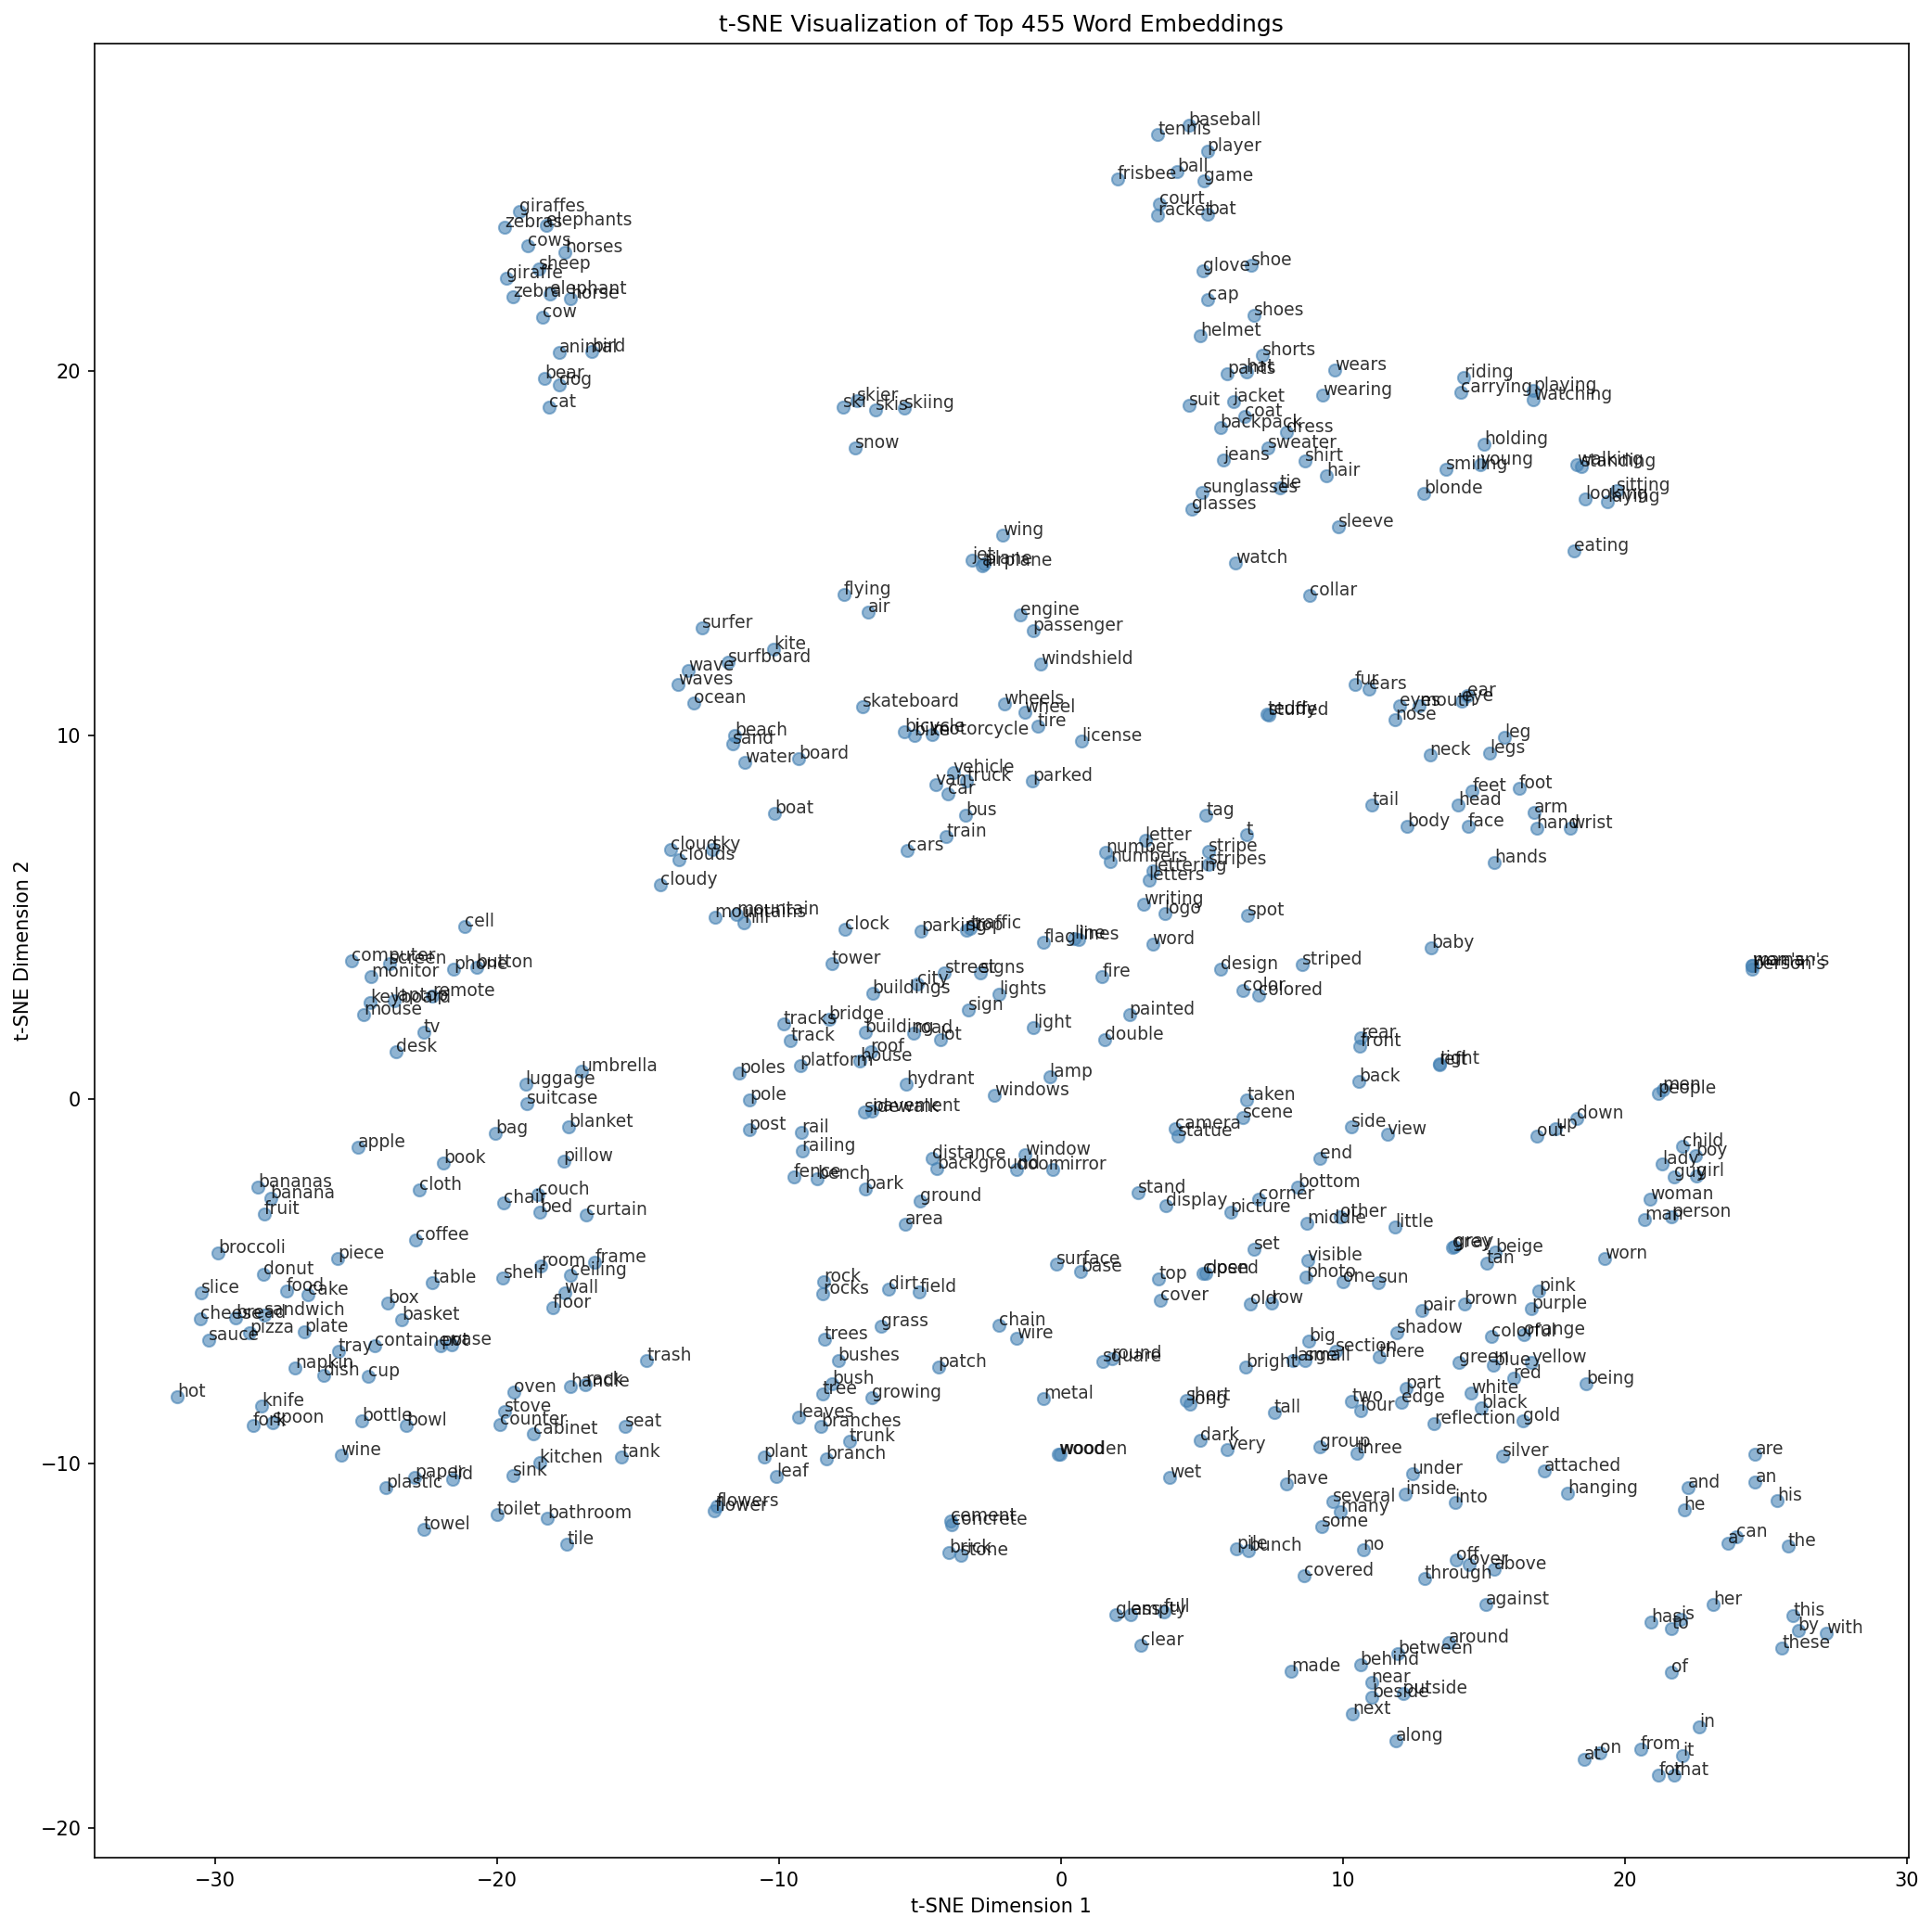

In [6]:
from src.lab6_current_best import analyze_embeddings, visualize_embeddings, SkipGramModel
import torch
import os
import numpy as np
from IPython.display import Image, display

# --- 1. Load Best Model ---
# We load the model, nodes, and embeddings saved by train_embeddings
model_path = 'best_model.pth'
if os.path.exists(model_path):
    print(f"Loading best model from {model_path}...")
    checkpoint = torch.load(model_path)
    nodes = checkpoint['nodes']

    # Reconstruct model to get final (non-detached) embeddings
    # Note: We use .get_embeddings() which returns the center_embeddings
    model = SkipGramModel(checkpoint['vocab_size'], checkpoint['embedding_dim'])
    model.load_state_dict(checkpoint['model_state_dict'])
    
    embeddings = model.get_embeddings()
    

    print(f"✅ Loaded embeddings for {len(nodes):,} words")
else:
    print("❌ Error: No saved model found!")
    print("Please run the training cell above before proceeding.")
    # Raise an error to stop execution if the model is missing
    raise FileNotFoundError(f"{model_path} not found. Please train the model first.")

# --- 2. Qualitative Analysis ---
# Now we use the helper functions to probe what the model learned.
# We'll check for nearest neighbors (semantics) and analogies (linear structure).
analyze_embeddings(
    nodes=nodes,
    embeddings=embeddings,

    # --- Nearest neighbors ---
    # Probe visual semantics, attributes, and compositional structure
    similarity_examples=[
        # People and roles
        "man", "woman", "child", "boy", "girl", "person",
        # Scene elements
        "tree", "building", "sky", "street", "car", "table",
        # Colors and materials
        "red", "blue", "green", "black", "white", "wooden", "metal",
        # Actions
        "walking", "sitting", "holding", "riding", "standing",
        # Textures / objects
        "water", "grass", "sand", "snow", "wall"
    ],

    # --- Analogies ---
    # a : b :: c : ?
    #  → test if embedding geometry captures color, role, size, material, and action relations
    analogy_examples=[
        # Color analogies
        ("red", "apple", "yellow"),        # → banana?
        ("blue", "sky", "green"),          # → grass?
        ("white", "snow", "brown"),        # → dirt or wood?

        # Role analogies
        ("man", "woman", "boy"),           # → girl?
        ("boy", "girl", "man"),            # → woman?
        ("person", "hat", "hand"),         # → glove?

        # Size / quantity / attribute analogies
        ("long", "short", "tall"),         # → short?
        ("one", "two", "three"),           # → four?

        # Action and object use
        ("dog", "walking", "cat"),         # → sitting?
        ("person", "riding", "boat"),      # → sitting or water?
        ("pizza", "eating", "umbrella"),   # → holding?

        # Material / context
        ("metal", "car", "wooden"),        # → table?
        ("water", "boat", "road"),         # → car?
    ],

    # --- Semantic clusters ---
    # seeds chosen to reveal structure in scene-object relationships
    cluster_seeds=[
        "red", "blue", "green",          # color cluster
        "man", "woman", "child",         # human cluster
        "dog", "cat", "horse", "bird",   # animal cluster
        "building", "house", "street",   # architecture/scene
        "sky", "clouds", "water", "grass", # natural elements
        "car", "bus", "bicycle", "train" # vehicles
    ]
)

# --- 3. t-SNE Visualization ---
# We'll create a 2D plot of the *most frequent* words
# NOTE: Visualizing all 10k+ words is too slow and unreadable.
# The function defaults to the top 200, we'll use 300.
print("\n" + "="*80)
print("VISUALIZING EMBEDDINGS")
print("="*80)
print("Generating t-SNE plot for the top 300 words...")
print("(This may take a moment...)")

tsne_file = "embeddings_tsne.png"
visualize_embeddings(
    nodes,
    embeddings,
    output_file=tsne_file,
    sample_size=len(nodes),
    annotate=True
)

# Display the generated plot
if os.path.exists(tsne_file):
    print(f"\n📈 Displaying t-SNE visualization from {tsne_file}:")
    display(Image(filename=tsne_file, width=800))
else:
    print(f"\n(Plot file {tsne_file} not found.)")

In [6]:
from lab6 import run_tests

print("="*80)
print("🧪 RUNNING UNIT TESTS")
print("="*80)
print("This will test your implementations of SkipGramDataset and SkipGramModel.")
print("It's crucial that you test your implementations in this lab.")

# This function will run all tests defined in the lab6.py file
# Look for an "OK" or "PASSED" summary at the end.
success = run_tests()

print("\n" + "="*80)
if success:
    print("✅ All tests passed! You are ready to move on to the next step.")
else:
    print("❌ Some tests failed. Please review the errors above and fix your code.")
print("="*80)


----------------------------------------------------------------------
Ran 0 tests in 0.000s

OK


🧪 RUNNING UNIT TESTS
This will test your implementations of SkipGramDataset and SkipGramModel.
It's crucial that you test your implementations in this lab.
RUNNING SKIP-GRAM UNIT TESTS

✅ ALL TESTS PASSED!
Total tests run: 0

✅ All tests passed! You are ready to move on to the next step.
